In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
/home/corbin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
limit_mem()

# Basic Style Transfer

In this notebook, we will be implementing Neural Style Transfer, seperating content and style from various images. We can take the content of one image and apply the style (the colors and textures) of a different image to it.

First, let's load our starting images

## Load Images

### Content

In [2]:
imagenet_pth = '/data/imagenet/sample/train/'

In [3]:
all_images = glob.glob(imagenet_pth+'*/*'); len(all_images)

19439

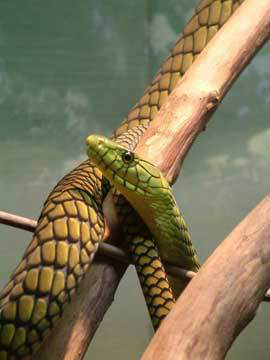

In [4]:
file = all_images[17600]
img = Image.open(file); img

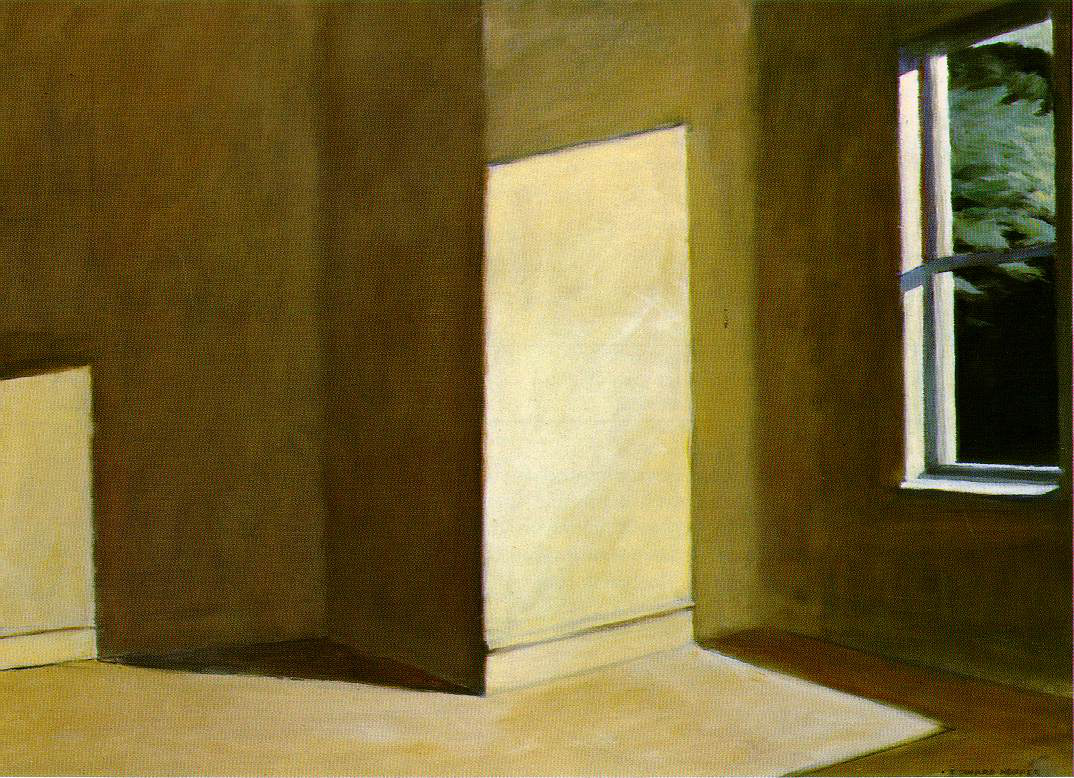

In [6]:
img = Image.open('data/edhop9.jpeg'); img

In [7]:
img.size

(1074, 778)

### Style

Because both images will be going through the same model (do they really need to though...?), we want to resize the style image to the same as the content.

In [5]:
sty_dir = 'data/crying_girl_1964.jpg'

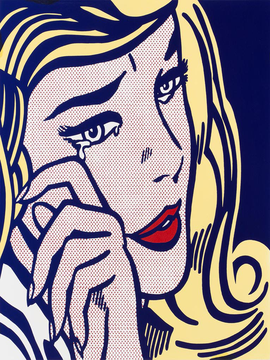

In [6]:
style = Image.open(sty_dir).resize(img.size, Image.ANTIALIAS); style

## Preprocess for VGG

Since we will be using VGG, some preprocessing is necessary. They subtract the mean RGB of ImageNet from each image and reverse the color order to BGR.

In [10]:
rgb_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x : (x - rgb_mean)[:, :, :, ::-1]

To plot, we will need to undo this.

In [11]:
deproc = lambda x, s : np.clip(x.reshape(s)[:, :, :, ::-1] + rgb_mean, 0, 255)

In [12]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
style_arr = preproc(np.expand_dims(np.array(style), 0))

In [13]:
img_shape = img_arr.shape
sty_shape = style_arr.shape
img_shape, sty_shape

((1, 778, 1074, 3), (1, 778, 1074, 3))

## Build models

In [14]:
input_shape = img_arr.shape[1:]; input_shape

(778, 1074, 3)

In [15]:
model = VGG16_Avg(include_top=False, input_shape=input_shape)

### Content

Need to build the outputs.

In [16]:
cont_output = model.get_layer('block5_conv1').output; cont_output

<tf.Tensor 'block5_conv1/Relu:0' shape=(?, 48, 67, 512) dtype=float32>

In [17]:
from keras.models import Model

In [39]:
cont_model = Model(model.input, cont_output)
targ = K.variable(cont_model.predict(img_arr))

In [40]:
class Evaluator(object):
    def __init__(self, func, img_shape): self.func, self.img_shape = func, img_shape
        
    def loss(self, x):
        loss_, self.grad_matrix = self.func([x.reshape(img_shape)])
        return loss_.astype(np.float64)
    
    def grads(self, x): return self.grad_matrix.flatten().astype(np.float64)

In [41]:
loss = K.mean(metrics.mse(cont_output, targ))
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss] + grads)
eval_obj = Evaluator(fn, img_shape)

In [44]:
img_prog_path = './results/'

In [45]:
def recreate_content(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(), fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127, 127)
        
        print('Current loss value:', min_val)
        imsave(f'{img_prog_path}res_at_iteration_{i}.png', deproc(x.copy(), img_shape)[0])
    return x

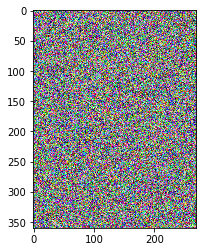

In [46]:
rand_img = lambda shape: np.random.uniform(0, 255, shape)
x = rand_img(img_shape)
plt.imshow(x[0])

In [47]:
iters = 10

In [81]:
x = recreate_content(eval_obj, iters, x)

Current loss value: 11.6495456696
Current loss value: 11.6131343842
Current loss value: 11.6066274643
Current loss value: 11.596075058
Current loss value: 11.5878067017
Current loss value: 11.581079483
Current loss value: 11.5552120209
Current loss value: 11.4594707489
Current loss value: 11.4704065323
Current loss value: 11.4520988464


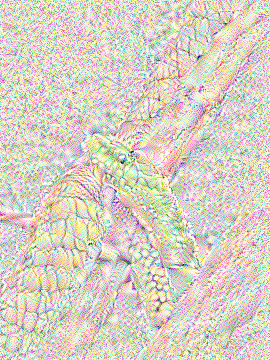

In [82]:
Image.open(img_prog_path+'res_at_iteration_9.png')

In [83]:
from IPython.display import HTML
from matplotlib import animation

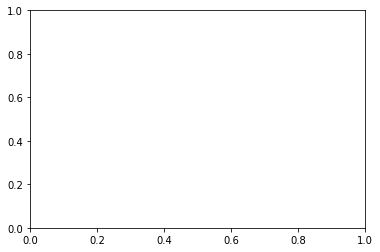

In [317]:
from IPython.display import HTML
from matplotlib import animation
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{img_prog_path}res_at_iteration_{i}.png'))

In [85]:
anim = animation.FuncAnimation(fig,animate, frames = 10, interval = 200)
HTML(anim.to_html5_video())

And that's all she wrote. Now onto style recreation

## Style

In [86]:
def plot_arr(array): plt.imshow(deproc(array, array.shape)[0].astype('uint8'))

Let's remind ourselves what the image looks like

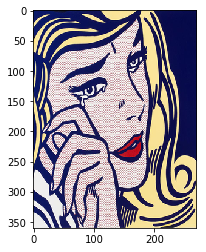

In [87]:
plot_arr(style_arr)

Again, we want to recreate the colors and textures of this image. To begin, the model is going to accept the same thing as input, an image of the same size as before, but output is going to change to multiple layers.

In [88]:
total_conv_blocks = 5

In [89]:
output_dict = {layer.name : layer.output for layer in model.layers}

In [90]:
model_outs = [output_dict['block{}_conv1'.format(o)] for o in range(1, total_conv_blocks + 1)]

In [91]:
model_outs

[<tf.Tensor 'block1_conv1/Relu:0' shape=(?, 360, 270, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 180, 135, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 90, 67, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu:0' shape=(?, 45, 33, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1/Relu:0' shape=(?, 22, 16, 512) dtype=float32>]

In [92]:
sty_model = Model(model.inputs, model_outs)
targs = [K.variable(o) for o in sty_model.predict(style_arr)]

To access the 'style', we take a gramian matrix, which is defined as thus:

In [93]:
def gram_matrix(orig_mat):
    # First, change the dimensionality to have RGB channels first, 
    # then flatten along the RGB channels (hence batch_ instead of normal flatten() )
    features = K.batch_flatten(K.permute_dimensions(orig_mat, (2, 0, 1)))
    # This, transposed with itself
    return K.dot(features, K.transpose(features)) / orig_mat.get_shape().num_elements()
    # Dividing by x.get_shape().num_elements() is not strictly necessary,
    # but for our loss function, it is important to have content and style
    # loss on the same scale, hence this division.

In [94]:
def style_loss(x, targs): return metrics.mse(gram_matrix(x), gram_matrix(targs))

In [96]:
loss = sum(K.mean(style_loss(l1[0], l2[0])) for l1, l2 in zip(model_outs, targs))
grads = K.gradients(loss, model.input)
sty_fn = K.function([model.input], [loss] + grads)
eval_obj = Evaluator(sty_fn, sty_shape)

In [97]:
rand_img = lambda shape: np.random.uniform(0, 255, shape)
x = rand_img(sty_shape)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

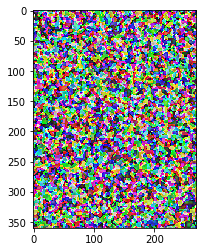

In [98]:
plt.imshow(x[0])

In [105]:
iters = 50

In [106]:
x = recreate_content(eval_obj, iters, x)

Current loss value: 32862.5429688
Current loss value: 32310.8476562
Current loss value: 31763.9121094
Current loss value: 31230.6425781
Current loss value: 30710.4472656
Current loss value: 30192.8144531
Current loss value: 29693.3359375
Current loss value: 29212.2148438
Current loss value: 28734.0351562
Current loss value: 28266.8710938
Current loss value: 28180.9433594
Current loss value: 27650.9960938
Current loss value: 27206.5605469
Current loss value: 27127.2597656
Current loss value: 26620.4863281
Current loss value: 23633.3730469
Current loss value: 23662.4882812
Current loss value: 23481.3144531
Current loss value: 23318.4238281
Current loss value: 23168.5800781
Current loss value: 23027.0585938
Current loss value: 22529.4960938
Current loss value: 22106.0644531
Current loss value: 22042.2324219
Current loss value: 21630.3164062
Current loss value: 21567.8808594
Current loss value: 21157.703125
Current loss value: 21107.3789062
Current loss value: 20724.7871094
Current loss va

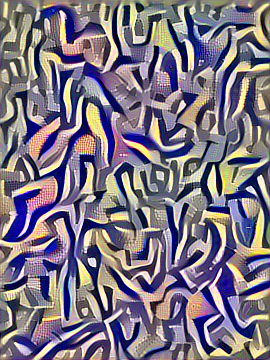

In [107]:
Image.open(f'{img_prog_path}res_at_iteration_49.png')

In [109]:
anim = animation.FuncAnimation(fig,animate, frames = 50, interval = 200)
HTML(anim.to_html5_video())

Not bad! Alright, now to combine style and content loss into a singular function.

# Bringing it all together

To understand how all the parts fit in together, we will clear and redeclare all relavent variables.

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [57]:
%matplotlib inline
import utils2
from keras.models import Model
import keras.backend as K
import numpy as np

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from scipy.ndimage import gaussian_filter
from keras import metrics
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

from vgg16_avg import VGG16_Avg

In [3]:
utils2.limit_mem()

## Load Images

### Content

In [4]:
imagenet_imgs = glob('/data/imagenet/sample/train/*/*'); len(imagenet_imgs)

19439

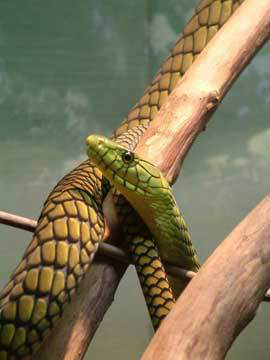

In [5]:
img = Image.open(imagenet_imgs[17600]); img

In [6]:
size = img.size; size

(270, 360)

### Style

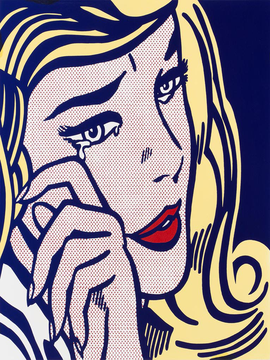

In [7]:
sty = Image.open('./data/crying_girl_1964.jpg').resize(size, Image.ANTIALIAS); sty

## VGG Preprocess

In [8]:
rgb_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: np.array(x - rgb_mean)[:, :, :, ::-1]

In [9]:
deproc = lambda x, shape: np.clip(x.reshape(shape)[:, :, :, ::-1] + rgb_mean, 0, 255)

In [10]:
img_arr = preproc(np.expand_dims(img, 0))
sty_arr = preproc(np.expand_dims(sty, 0))
shape = img_arr.shape; shape

(1, 360, 270, 3)

## Build the model

In [11]:
model = VGG16_Avg(include_top=False, input_shape=shape[1:])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 360, 270, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 270, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 270, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 180, 135, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 135, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 135, 128)     147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, 90, 67, 128)       0         
__________

In [13]:
name2output = {l.name: l.output for l in model.layers}

In [14]:
outputs = [name2output['block{}_conv2'.format(o)] for o in range(1,6)]

In [15]:
nst_model = Model(model.input, outputs)

This time, I'm going to take content loss from the same layers I take style loss from in order to use the same model. We'll see how it comes out.

In [16]:
cont_targs = [K.variable(o) for o in nst_model.predict(img_arr)]
sty_targs = [K.variable(o) for o in nst_model.predict(sty_arr)]

## Define loss/grad, etc.

Let's remind ourselves that for style loss, we take the sum if the mse of the gram matrix for our target and noise. Let's redefine that here.

In [ ]:
K.batch_flatten()

In [17]:
def gram_mat(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [18]:
def sty_loss(targ, layer): return K.mean(metrics.mse(gram_mat(targ), gram_mat(layer)))

We now need to define the loss functions for both content and style. The only real difference between these two losses is that the style transfer goes through the gramian matrix function.

In [19]:
cont_loss = sum(K.mean(metrics.mse(cont_targ[0], cont_outp[0])) 
                for cont_targ, cont_outp in zip(cont_targs, outputs))
style_loss = sum(sty_loss(sty_targ[0], sty_outp[0]) 
                 for sty_targ, sty_outp in zip(sty_targs, outputs))

In [20]:
loss = cont_loss + style_loss
grad = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grad)

In [21]:
class Evaluator(object):
    def __init__(self, func, shape): self.func, self.shp = func, shape
    
    def loss(self, x):
        loss_, self.grads_ = self.func([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x): return self.grads_.flatten().astype(np.float64)

In [22]:
eval_obj = Evaluator(fn, shape)

## Create Noise

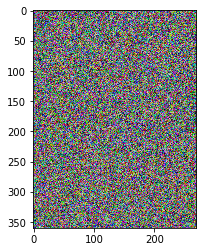

In [84]:
noise = lambda shape: np.random.uniform(0, 225, size=shape)
x = noise(shape)
plt.imshow(x[0].astype('uint8'));

In [44]:
#x = img

In [45]:
#x = np.expand_dims(x, 0)

In [46]:
#x.shape

## Define training loop and train

In [47]:
def train(x, shape, eval_obj, iters):
    for i in range(iters):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(), 
                                         fprime=eval_obj.grads, maxfun=20)
        np.clip(x, -127, 127)
        print('Current loss: {}'.format(min_val))
        imsave(f'./results/res_at_iteration_{i}.png', deproc(x.copy(), shape)[0])
    return x

In [48]:
iters = 100
x = train(x, shape, eval_obj, iters)

Current loss: 2015876.25
Current loss: 1931298.5
Current loss: 1855025.75
Current loss: 1785705.25
Current loss: 1578378.375
Current loss: 1487008.0
Current loss: 1243425.0
Current loss: 1130594.875
Current loss: 1065109.375
Current loss: 1042320.5
Current loss: 1009269.8125
Current loss: 984746.25
Current loss: 925441.0
Current loss: 873132.9375
Current loss: 822142.4375
Current loss: 816953.25
Current loss: 812261.875
Current loss: 797608.0
Current loss: 786819.8125
Current loss: 772691.0
Current loss: 760335.8125
Current loss: 754852.25
Current loss: 712512.875
Current loss: 686562.25
Current loss: 672708.5
Current loss: 663974.1875
Current loss: 660082.5
Current loss: 655946.25
Current loss: 642207.1875
Current loss: 633145.25
Current loss: 625371.0
Current loss: 623021.9375
Current loss: 618560.625
Current loss: 609440.375
Current loss: 605241.75
Current loss: 604481.125
Current loss: 600974.5625
Current loss: 597356.875
Current loss: 591821.0625
Current loss: 590239.6875
Current 

## Visualize Results

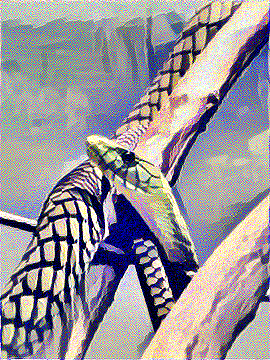

In [54]:
result = Image.open('./results/res_at_iteration_99.png'); result

In [55]:
import IPython.display as disp

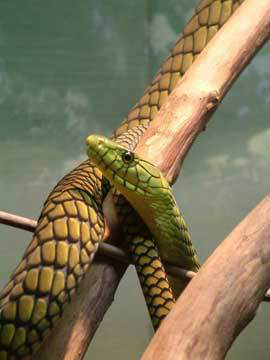

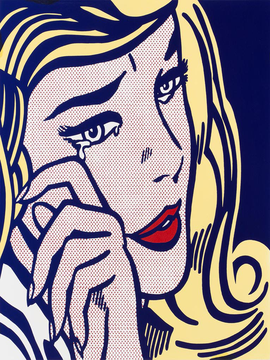

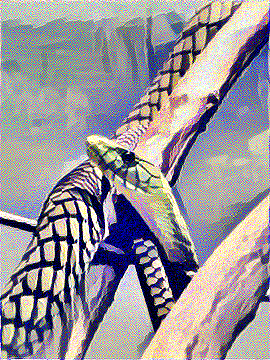

In [56]:
disp.display(img, sty, result)

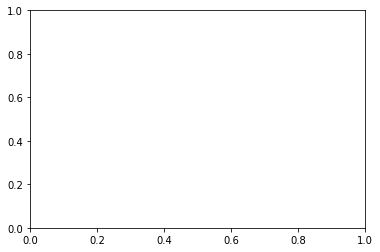

In [52]:
img_prog_path = './results/'
from IPython.display import HTML
from matplotlib import animation
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{img_prog_path}res_at_iteration_{i}.png'))

In [53]:
anim = animation.FuncAnimation(fig,animate, frames = 100, interval = 100)
HTML(anim.to_html5_video())